In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [1]:
import keras.losses
import keras.optimizers
from keras.models import Sequential, Model
from keras.layers import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from constants import *

Using TensorFlow backend.


# Get data

In [2]:
import json
import pickle
import h5py

In [3]:
# open data files
hf_train = h5py.File('data/train_data.h5', 'r')
hf_test = h5py.File('data/test_data.h5', 'r')

In [4]:
im_train = hf_train.get('im_train')
q_train = hf_train.get('q_train')
bow_q_train = hf_train.get('bow_q_train')
y_train = hf_train.get('y_train')

im_test = hf_test.get('im_test')
q_test = hf_test.get('q_test')
bow_q_test = hf_test.get('bow_q_test')
y_test = hf_test.get('y_test')

# create small subset of test data
im_val = im_test[:1000,:].astype('float32')
q_val = q_test[:1000,:].astype('float32')
bow_q_val = bow_q_test[:1000,:].astype('float32')
y_val = y_test[:1000].astype('float32')

# Create models

## LSTM Q + I

In [23]:
# define the tensors for the two inputs
q_input_shape = (MAX_Q_LEN, WORD_EMBED_DIM)
im_input_shape = (2048,)

q_input = Input(q_input_shape)
im_input = Input(im_input_shape)

In [24]:
# LSTM Q
q_model = Sequential([
  LSTM(512, input_shape=q_input_shape),
  Dropout(0.2),
  Dense(1024, activation='tanh')
])

q_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
q_model.summary()

# I
im_model = Sequential([
  Dense(1024, input_shape=im_input_shape, activation='relu')
])

im_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
im_model.summary()

# LSTM Q + I
encoded_q = q_model(q_input) # encodings for the question and image
encoded_im = im_model(im_input)
    
# add a customized layer to compute element-wise multiplication 
# between question and image vector
merge_layer = Multiply()([encoded_q, encoded_im])
dense = Dense(1024, activation='relu')(merge_layer)
dropout = Dropout(0.2)(dense)
prediction = Dense(1001, activation='softmax')(dropout)

RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_a = Model(inputs=[q_input, im_input], outputs=prediction)
model_a.compile(optimizer=RMSprop,  # optimizer
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model_a.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 512)               1071104   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              525312    
Total params: 1,596,416
Trainable params: 1,596,416
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              2098176   
Total params: 2,098,176
Trainable params: 2,098,176
Non-trainable params: 0
_________________________________________________________________
Model: "mode

#### Train model

In [80]:
history_a = model_a.fit([q_train, im_train], y_train,
                    batch_size=512,
                    epochs=5,
                    shuffle='batch',
                    validation_data=([q_val, im_val], y_val))

Train on 443757 samples, validate on 1000 samples
Epoch 1/5
443757/443757 [==============================] - 92s 207us/step - loss: 1.6289 - sparse_categorical_accuracy: 0.4887 - val_loss: 1.6396 - val_sparse_categorical_accuracy: 0.4640
Epoch 2/5
443757/443757 [==============================] - 92s 208us/step - loss: 1.6146 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.7178 - val_sparse_categorical_accuracy: 0.4930
Epoch 3/5
443757/443757 [==============================] - 92s 208us/step - loss: 1.5989 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.6705 - val_sparse_categorical_accuracy: 0.4710
Epoch 4/5
443757/443757 [==============================] - 92s 208us/step - loss: 1.5854 - sparse_categorical_accuracy: 0.4982 - val_loss: 1.6490 - val_sparse_categorical_accuracy: 0.4870
Epoch 5/5
443757/443757 [==============================] - 92s 208us/step - loss: 1.5749 - sparse_categorical_accuracy: 0.5007 - val_loss: 1.6986 - val_sparse_categorical_accuracy: 0.4830


In [11]:
model_a = keras.models.load_model('models/LSTMQ_I.h5')

#### Evaluate model

In [12]:
results = model_a.evaluate([q_test, im_test], y_test, batch_size=128)
print('test loss, test acc:', results)

214354/214354 [==============================] - 45s 212us/step
test loss, test acc: [1.7779347890647552, 0.4836765229701996]


In [36]:
predictions_a = model_a.predict([q_test, im_test], verbose=1)

predict_a = np.argmax(predictions_a, axis=1)
np.savetxt('predictions/predict_a.dat', predict_a)

214354/214354 [==============================] - 58s 271us/step


In [61]:
print(predict_a)

[ 0 39 45 ...  0 23  1]


#### Analysis of results

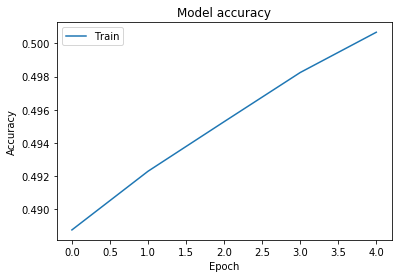

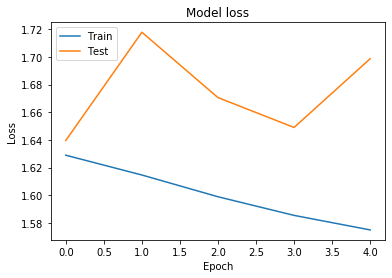

In [83]:
# plot training & validation accuracy values
plt.plot(history_a.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history_a.history['loss'])
plt.plot(history_a.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## deeper LSTM Q + I

In [26]:
# deeper LSTM Q
q_model = Sequential([
  LSTM(512, return_sequences=True, input_shape=q_input_shape),
  Dropout(0.2),
  LSTM(512, return_sequences=False),
  Dense(1024, activation='tanh')
])

q_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
q_model.summary()

# I
im_model = Sequential([
  Dense(1024, input_shape=im_input_shape, activation='relu')
])

im_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
im_model.summary()

# deeper LSTM Q + I
encoded_q = q_model(q_input) # encodings for the question and image
encoded_im = im_model(im_input)
    
# add a customized layer to compute element-wise multiplication 
# between question and image vector
merge_layer = Multiply()([encoded_q, encoded_im])
dense = Dense(1024, activation='relu')(merge_layer)
dropout = Dropout(0.2)(dense)
prediction = Dense(1001, activation='softmax')(dropout)

RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_b = Model(inputs=[q_input, im_input], outputs=prediction)
model_b.compile(optimizer=RMSprop,  # optimizer
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model_b.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 22, 512)           1071104   
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              525312    
Total params: 3,695,616
Trainable params: 3,695,616
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              2098176   
Total params: 2,098,1

In [84]:
history_b = model_b.fit([q_train, im_train], y_train,
                    batch_size=512,
                    epochs=5,
                    shuffle='batch',
                    validation_data=([q_val, im_val], y_val))

Train on 443757 samples, validate on 1000 samples
Epoch 1/5
443757/443757 [==============================] - 199s 449us/step - loss: 1.6854 - sparse_categorical_accuracy: 0.4758 - val_loss: 1.6961 - val_sparse_categorical_accuracy: 0.4750
Epoch 2/5
443757/443757 [==============================] - 198s 446us/step - loss: 1.6675 - sparse_categorical_accuracy: 0.4802 - val_loss: 1.6552 - val_sparse_categorical_accuracy: 0.4770
Epoch 3/5
443757/443757 [==============================] - 198s 447us/step - loss: 1.6490 - sparse_categorical_accuracy: 0.4823 - val_loss: 1.6300 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/5
443757/443757 [==============================] - 196s 442us/step - loss: 1.6314 - sparse_categorical_accuracy: 0.4870 - val_loss: 1.6858 - val_sparse_categorical_accuracy: 0.4740
Epoch 5/5
443757/443757 [==============================] - 198s 445us/step - loss: 1.6175 - sparse_categorical_accuracy: 0.4897 - val_loss: 1.6463 - val_sparse_categorical_accuracy: 0.4680


In [33]:
# model_b.save('data/deeperLSTMQ_I.h5')
model_b = keras.models.load_model('models/deeperLSTMQ_I.h5')

In [86]:
results = model_b.evaluate([q_test, im_test], y_test, batch_size=128)
print('test loss, test acc:', results)

214354/214354 [==============================] - 47s 220us/step
test loss, test acc: [1.7301265623487248, 0.4787501096725464]


In [35]:
predictions_b = model_b.predict([q_test, im_test], verbose=1)

predict_b = np.argmax(predictions_b, axis=1)
np.savetxt('predictions/predict_b.dat', predict_b)

214354/214354 [==============================] - 111s 520us/step


In [60]:
print(predict_b)

[ 0 39 45 ...  0 22  2]


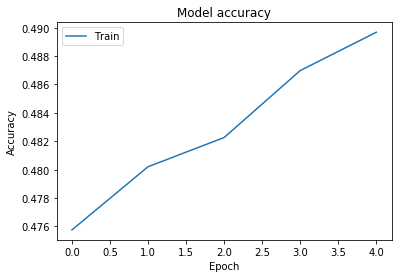

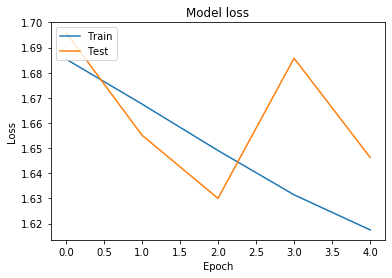

In [87]:
# plot training & validation accuracy values
plt.plot(history_b.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history_b.history['loss'])
plt.plot(history_b.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## LSTM Q concat I

In [28]:
# LSTM Q
q_model = Sequential([
  LSTM(512, input_shape=q_input_shape),
  Dropout(0.2),
  Dense(512, activation='tanh')
])

q_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
q_model.summary()

# I
im_model = Sequential([
  Dense(512, input_shape=im_input_shape, activation='relu')
])

im_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
im_model.summary()

# LSTM Q + I
encoded_q = q_model(q_input) # encodings for the question and image
encoded_im = im_model(im_input)
    
# add a customized layer to compute element-wise multiplication 
# between question and image vector
merge_layer = Concatenate()([encoded_q, encoded_im])
dense = Dense(1024, activation='relu')(merge_layer)
dropout = Dropout(0.2)(dense)
prediction = Dense(1001, activation='softmax')(dropout)

RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_c = Model(inputs=[q_input, im_input], outputs=prediction)
model_c.compile(optimizer=RMSprop,  # optimizer
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model_c.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 512)               1071104   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
Total params: 1,333,760
Trainable params: 1,333,760
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               1049088   
Total params: 1,049,088
Trainable params: 1,049,088
Non-trainable params: 0
_________________________________________________________________
Model: "mo

In [46]:
history_c = model_c.fit([q_train, im_train], y_train,
                    batch_size=512,
                    epochs=10,
                    shuffle='batch',
                    validation_data=([q_val, im_val], y_val))

Train on 443757 samples, validate on 1000 samples
Epoch 1/10
443757/443757 [==============================] - 313s 704us/step - loss: 1.8837 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.7970 - val_sparse_categorical_accuracy: 0.4490
Epoch 2/10
443757/443757 [==============================] - 92s 206us/step - loss: 1.8617 - sparse_categorical_accuracy: 0.4440 - val_loss: 1.7781 - val_sparse_categorical_accuracy: 0.4410
Epoch 3/10
443757/443757 [==============================] - 92s 207us/step - loss: 1.8447 - sparse_categorical_accuracy: 0.4449 - val_loss: 1.7862 - val_sparse_categorical_accuracy: 0.4270
Epoch 4/10
443757/443757 [==============================] - 91s 206us/step - loss: 1.8333 - sparse_categorical_accuracy: 0.4469 - val_loss: 1.7834 - val_sparse_categorical_accuracy: 0.4390
Epoch 5/10
443757/443757 [==============================] - 92s 207us/step - loss: 1.8216 - sparse_categorical_accuracy: 0.4490 - val_loss: 1.7968 - val_sparse_categorical_accuracy: 0.4370
Epoc

KeyboardInterrupt: 

In [49]:
# model_c.save('models/LSTMQ_concatI.h5')
model_c = keras.models.load_model('models/LSTMQ_concatI.h5')

In [50]:
results = model_c.evaluate([q_test, im_test], y_test, batch_size=128)
print('test loss, test acc:', results)

214354/214354 [==============================] - 27s 125us/step
test loss, test acc: [1.8590600806386761, 0.4532129168510437]


In [51]:
predictions_c = model_c.predict([q_test, im_test], verbose=1)


predict_c = np.argmax(predictions_c, axis=1)
np.savetxt('predictions/predict_c.dat', predict_c)

214354/214354 [==============================] - 61s 284us/step


In [59]:
print(predict_c)

[111  94  45 ...   0  22   1]


In [ ]:
# plot training & validation accuracy values
plt.plot(history_c.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history_c.history['loss'])
plt.plot(history_c.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## BoW + I

In [ ]:
from preprocessing import *

In [38]:
# define the tensors for the two inputs
q_input_shape = (MAX_Q_LEN,)
im_input_shape = (2048,)

# BoW
q_model = Sequential([
  Dense(512, input_shape=q_input_shape, activation='relu')
])

q_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
q_model.summary()

# I
im_model = Sequential([
  Dense(512, input_shape=im_input_shape, activation='relu')
])

im_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
im_model.summary()

# LSTM Q + I
q_input = Input(q_input_shape)
im_input = Input(im_input_shape)

encoded_q = q_model(q_input) # encodings for the question and image
encoded_im = im_model(im_input)
    
# add a customized layer to compute element-wise multiplication 
# between question and image vector
merge_layer = Concatenate()([encoded_q, encoded_im])
dense = Dense(1024, activation='relu')(merge_layer)
dropout = Dropout(0.2)(dense)
prediction = Dense(1001, activation='softmax')(dropout)

RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_d = Model(inputs=[q_input, im_input], outputs=prediction)
model_d.compile(optimizer=RMSprop,  # optimizer
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model_d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               11776     
Total params: 11,776
Trainable params: 11,776
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               1049088   
Total params: 1,049,088
Trainable params: 1,049,088
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22)           0             

In [101]:
history_d = model_d.fit([bow_q_train, im_train], y_train,
                    batch_size=512,
                    epochs=10,
                    shuffle='batch',
                    validation_data=([bow_q_val, im_val], y_val))

Train on 443757 samples, validate on 1000 samples
Epoch 1/10
443757/443757 [==============================] - 24s 54us/step - loss: 2.9401 - sparse_categorical_accuracy: 0.3241 - val_loss: 2.8672 - val_sparse_categorical_accuracy: 0.3230
Epoch 2/10
443757/443757 [==============================] - 24s 53us/step - loss: 2.9264 - sparse_categorical_accuracy: 0.3247 - val_loss: 2.7202 - val_sparse_categorical_accuracy: 0.3350
Epoch 3/10
443757/443757 [==============================] - 24s 55us/step - loss: 2.9084 - sparse_categorical_accuracy: 0.3276 - val_loss: 2.9073 - val_sparse_categorical_accuracy: 0.3370
Epoch 4/10
443757/443757 [==============================] - 25s 55us/step - loss: 2.9114 - sparse_categorical_accuracy: 0.3281 - val_loss: 2.7904 - val_sparse_categorical_accuracy: 0.3440
Epoch 5/10
443757/443757 [==============================] - 25s 55us/step - loss: 2.9193 - sparse_categorical_accuracy: 0.3268 - val_loss: 2.8925 - val_sparse_categorical_accuracy: 0.3540
Epoch 6/10

In [52]:
# model_d.save('data/BoW_I.h5')
model_d = keras.models.load_model('models/BoW_I.h5')

In [53]:
results = model_d.evaluate([bow_q_test, im_test], y_test, batch_size=128)
print('test loss, test acc:', results)

214354/214354 [==============================] - 11s 53us/step
test loss, test acc: [2.9133546858667527, 0.3343394696712494]


In [55]:
predictions_d = model_d.predict([bow_q_test, im_test], verbose=1)

predict_d = np.argmax(predictions_d, axis=1)
np.savetxt('predictions/predict_d.dat', predict_d)

214354/214354 [==============================] - 20s 93us/step


In [58]:
print(predict_d)

[0 0 0 ... 0 1 2]


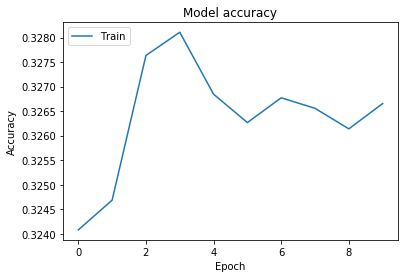

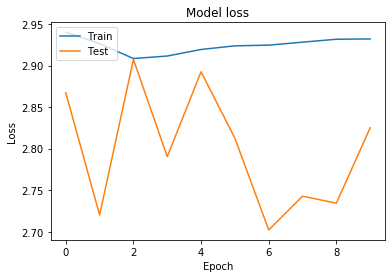

In [106]:
# plot training & validation accuracy values
plt.plot(history_d.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history_d.history['loss'])
plt.plot(history_d.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Improved model

In [5]:
# define the tensors for the two inputs
q_input_shape = (MAX_Q_LEN, WORD_EMBED_DIM)
im_input_shape = (2048,)

q_input = Input(q_input_shape)
im_input = Input(im_input_shape)

In [6]:
# LSTM Q
q_model = Sequential([
  LSTM(512, input_shape=q_input_shape),
  Dropout(0.2),
  Dense(256, activation='tanh')
])

q_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
q_model.summary()

# I
im_model = Sequential([
  Dense(512, input_shape=im_input_shape, activation='relu')
])

im_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
im_model.summary()

# LSTM Q + I
encoded_q = q_model(q_input) # encodings for the question and image
encoded_im = im_model(im_input)
    
# add a customized layer to compute element-wise multiplication 
# between question and image vector
merge_layer = Lambda((lambda tensors: tensors[0] @ tensors[1]), 
    output_shape = (256, 512))
dense = Dense(1024, activation='relu')(merge_layer)
dropout = Dropout(0.2)(dense)
prediction = Dense(1001, activation='softmax')(dropout)

RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_c = Model(inputs=[q_input, im_input], outputs=prediction)
model_c.compile(optimizer=RMSprop,  # optimizer
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1071104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
Total params: 1,202,432
Trainable params: 1,202,432
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               1049088   
Total params: 1,049,088
Trainable params: 1,049,088
Non-trainable params: 0
_________________________________________________________________


ValueError: Layer dense_3 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.core.Lambda'>. Full input: [<keras.layers.core.Lambda object at 0x7f8ea845a3d0>]. All inputs to the layer should be tensors.

In [62]:
hf_train.close()
hf_test.close()